In [1]:
import geopandas as gpd
from shapely.geometry import Point, shape
import matplotlib.pyplot as plt

import preprocessing.downloader as dl
    
ids = dl.fetch_ids_on_envirocar(num_trajectories=10)
print(len(ids))
print(ids)
print(type(ids))

10
['64c2bce5c7e42807e7b87a42', '64c2b669c7e42807e7b8797a', '64c29fd8c7e42807e7b83193', '64c29f90c7e42807e7b8312a', '64c28d5fc7e42807e7b823c5', '64c28a19c7e42807e7b81568', '64c2869dc7e42807e7b7f4ea', '64c2852cc7e42807e7b7f0dc', '64c28340c7e42807e7b7eb20', '64c27edfc7e42807e7b7df2f']
<class 'list'>


In [2]:
num_trajectories = 6
dir = "cache/envirocar-npz"
dl.save_trajectories_from_envirocar_as_npz(num_trajectories, dir, compressed=False)

64c2bce5c7e42807e7b87a42
64c2b669c7e42807e7b8797a
64c29fd8c7e42807e7b83193
64c29f90c7e42807e7b8312a
64c28d5fc7e42807e7b823c5
64c28a19c7e42807e7b81568


In following code, we calculate how far Euclidian distance and distance calculated by pyproj.Geod.line_length

max_x_diff:  0
max_y_diff:  0
max_dist_diff:  125.609728604611


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


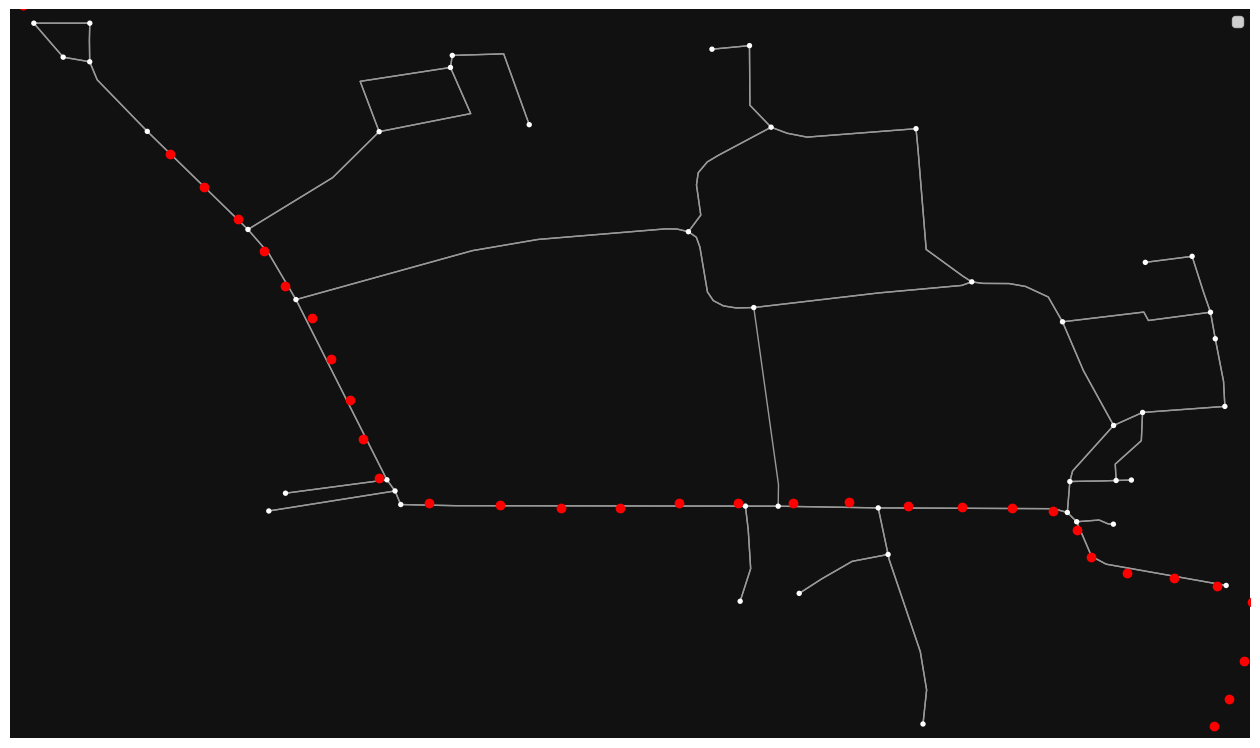

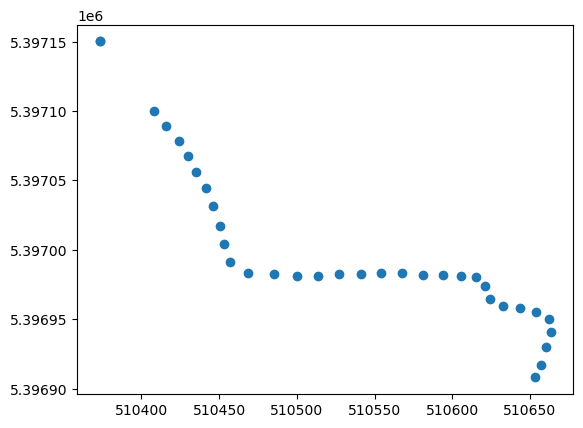

In [4]:
import os
import importlib
import math

import preprocessing.plotter as plotter
importlib.reload(dl)

def euclidian_distance(p, q):
    return math.sqrt((p[0]-q[0])*(p[0]-q[0])+(p[1]-q[1])*(p[1]-q[1]))

def geod_distance(geod, p, q):
    # The order of arguments is:
    # line_length(lons: Any, lats: Any, radians: bool = False) → float
    distance = geod.line_length([p[0], q[0]], [p[1], q[1]]) # https://pyproj4.github.io/pyproj/stable/api/geod.html#pyproj.Geod.line_length
    return distance

id = '64c2b669c7e42807e7b8797a'
file_name = f'envirocar-{id}.npz'
file_path = os.path.join(dir, file_name)
x, y, t, speed, direction, HDOP = dl.load_npz(file_path)

gdf = dl.download_from_envirocar(id)
geod = gdf.crs.get_geod()

gdf_lat = [p.x for p in gdf['lat_lon']]
gdf_lon = [p.y for p in gdf['lat_lon']]

assert len(x) == len(gdf_lat)
assert len(y) == len(gdf_lon)

max_x_diff = 0
max_y_diff = 0
max_dist_diff = 0
for i in range(len(x)):
    max_x_diff = max(max_x_diff, abs(x[i]-gdf['geometry'][i].x))
    max_y_diff = max(max_y_diff, abs(y[i]-gdf['geometry'][i].y))
    for j in range(i+1, len(x)):
        ed = euclidian_distance([x[i], y[i]], [x[j], y[j]])
        gd = geod_distance(geod, [gdf_lon[i], gdf_lat[i]], [gdf_lon[j], gdf_lat[j]])
        # print('Euclidian distance: ', ed)
        # print('Distance calculated by pyproj.Geod.line_length: ', gd)
        # print('abs(ed-gd): ', abs(ed-gd))
        max_dist_diff = max(max_dist_diff, abs(ed-gd))

print('max_x_diff: ', max_x_diff)
print('max_y_diff: ', max_y_diff)
print('max_dist_diff: ', max_dist_diff)

#### For Visualization
plotter.plot_trajectory(gdf)
plt.scatter(x, y)
plt.show()